## Chapter 2 – End-to-end Machine Learning project

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings 
import seaborn as sns

In [39]:
np.random.seed(42)
%matplotlib inline
mpl.rc('axes',labelsize = 14)
mpl.rc('xtick',labelsize = 20)
mpl.rc('ytick',labelsize = 20)
mpl.rc('axes',titlesize = 20)
warnings.filterwarnings(action='ignore')

In [3]:
sns.set_context('notebook')
sns.set_style('whitegrid')

### Function to save the plots

In [33]:
def save_fig(fig_id,tight_layout =True,fig_extension = 'png',resolution=300):
    path = os.path.join(fig_id,'.',fig_extension)
    print('Saving Figure :', fig_id)
    if tight_layout == True:
        plt.tight_layout()
    plt.savefig(fname = fig_id,format=fig_extension,dpi = resolution)

### Get the Data

In [5]:
housing = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv')

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [23]:
housing.total_bedrooms.isna().sum()

207

In [26]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Saving Figure : attributes_hist_plot


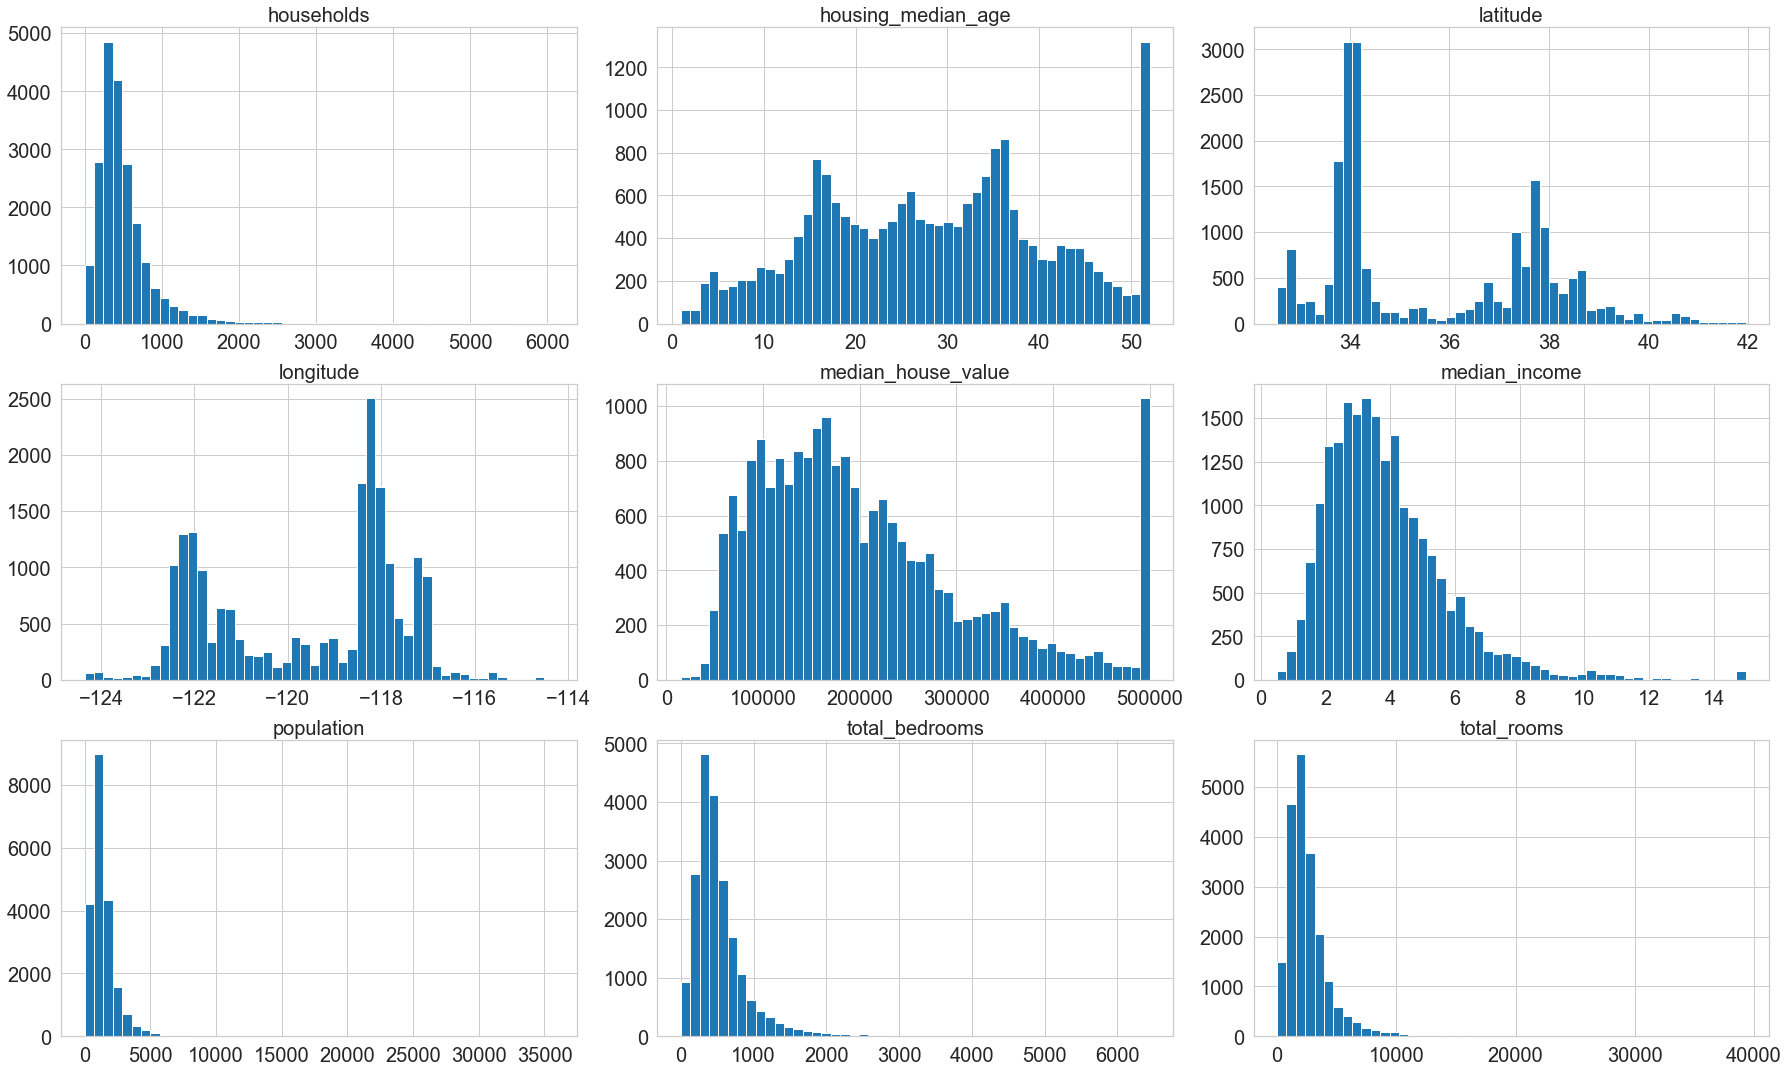

In [40]:
housing.hist(bins = 50,figsize=(25,15))
save_fig("attributes_hist_plot")

##### Notice a few things in these histograms:

* First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

* The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have two options:

    * Collect proper labels for the districts whose labels were capped.

    * Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).

* These attributes have very different scales. We will discuss this later in this chapter, when we explore feature scaling.

* Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

### Creating a Test Train split 

In [45]:
def split_train_test(data,test_ratio):
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_incides = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    print("The split was successful")
    return data.iloc[train_indices],data.iloc[test_incides]

In [46]:
train_set,test_set = split_train_test(housing,0.2)

The split was successful


In [48]:
len(train_set),len(test_set)

(16512, 4128)

In [50]:
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(housing,test_size = 0.2 ,random_state = 42)

In [51]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


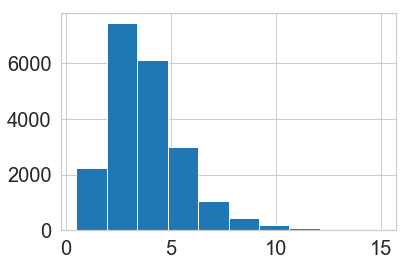

In [53]:
housing.median_income.hist()

In [52]:
housing['income_cat'] = pd.cut(housing.median_income,bins = [0.0,1.5,3.0,4.5,6.0,np.inf],labels=[1,2,3,4,5])

In [55]:
housing.income_cat.value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

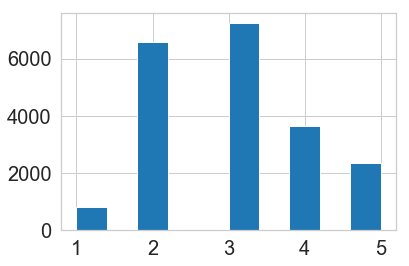

In [56]:
housing.income_cat.hist()

In [58]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20,random_state = 42)
for train_index,test_index in split.split(housing,housing.income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

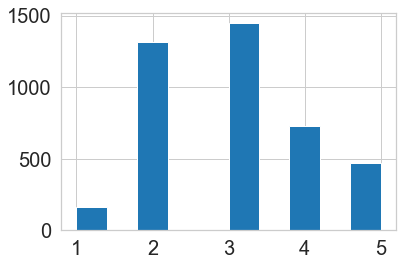

In [60]:
strat_test_set.income_cat.hist()

In [61]:
housing.income_cat.value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [63]:
strat_train_set.income_cat.value_counts()/len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [64]:
strat_test_set.income_cat.value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [71]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_prope = pd.DataFrame({
    'Overall': housing.income_cat.value_counts()/len(housing),
    'Stratified' : strat_test_set.income_cat.value_counts()/len(strat_test_set),
    'Random' : test_set.income_cat.value_counts()/len(test_set)
}).sort_index()

compare_prope["Rand. %error"] = 100 * compare_prope["Random"] / compare_prope["Overall"] - 100
compare_prope["Strat. %error"] = 100 * compare_prope["Stratified"] / compare_prope["Overall"] - 100

In [72]:
compare_prope

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [76]:
strat_test_set.drop('income_cat',axis=1,inplace=True)

In [77]:
strat_train_set.drop('income_cat',axis=1,inplace=True)

In [78]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


### Discover and Visualize the Data to Gain Insights

In [79]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

Text(0,0.5,'latitude')

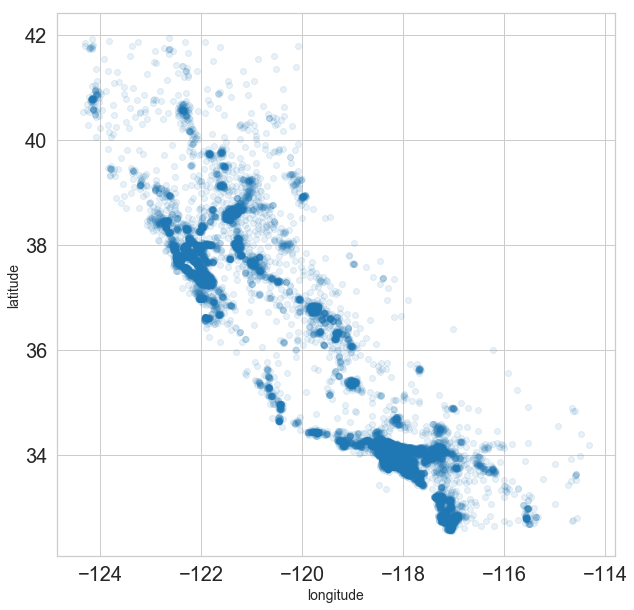

In [85]:
plt.figure(figsize = (10,10))
plt.scatter(housing.longitude,housing.latitude,alpha=0.1)
plt.xlabel('longitude')
plt.ylabel('latitude')

<Figure size 720x720 with 0 Axes>

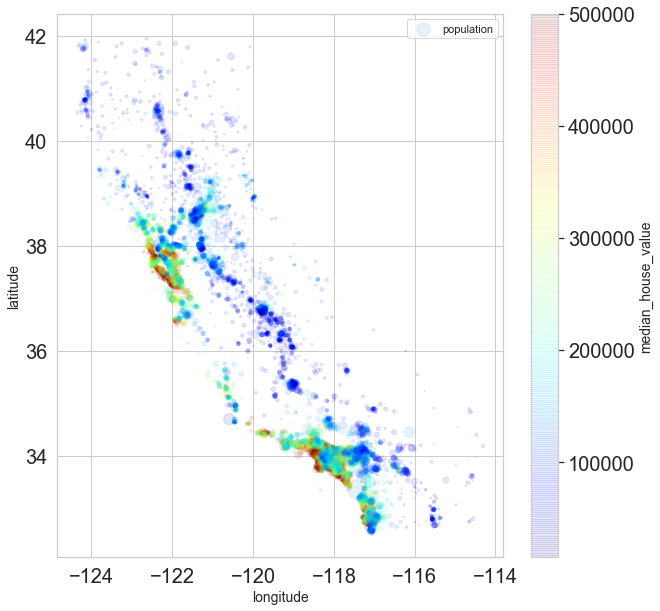

In [118]:
plt.figure(figsize = (10,10))
housing.plot(kind = 'scatter',x ='longitude',y ='latitude',alpha=0.1,figsize=(10,10),s = housing.population/100 ,label="population", c = 'median_house_value',cmap=plt.get_cmap('jet'),colorbar=True,
    sharex=False)
plt.legend()

Saving Figure : california_housing_prices_plot


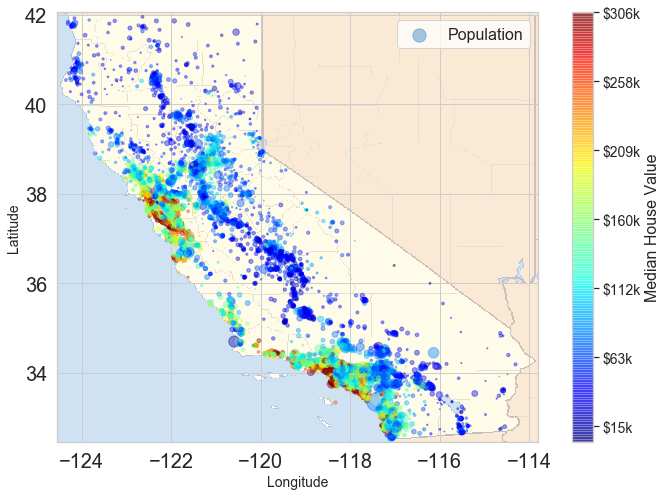

In [129]:
import matplotlib.image as mpimg
california_img = mpimg.imread('https://raw.githubusercontent.com/ageron/handson-ml2/master/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5, cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [130]:
corr_matrix = housing.corr()

In [132]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000
